In [30]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
import pyodbc

import matplotlib.pyplot as plt
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [21]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_notes from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC'"
df = pd.read_sql(query, sql_conn)
df.head()

,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_notes
0,QA,E6/7,MEDMED,RESP,WARD,NOHARM,NONE,None,N,N,N,on drug rounds found Amlodipine not given for ...
1,QA,C5,MEDMED,GENMED,WARD,HARM,LOW,None,Y,Y,Y,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...
2,QA,RHOPQ,SURMHN,RHEUM,HPBU,NOHARM,NONE,N,N,N,N,Patient changed to Nordiment from Oral Methotr...
3,QA,RHOPQ,SURMHN,RHEUM,HPBU,NOHARM,NONE,N,N,N,N,Reported as non clinical recoded to medication...
4,QA,RHOPQ,SURMHN,RHEUM,OPD,NOHARM,NONE,N,N,N,N,Reported 25/9/19 as patient /non-clinical even...


In [24]:
labels = list(df.columns.values)
labels.remove('inc_notes')
accuracies = []
for column in labels:
    df = df.dropna(subset=[column])
    y = df[column]
    X_train, X_test, y_train, y_test = train_test_split(
                                    df['inc_notes'], y,
                                    test_size=0.33,
                                    random_state=53)
    count_vectorizer = CountVectorizer(stop_words='english')
    count_train = count_vectorizer.fit_transform(X_train.values)
    count_test = count_vectorizer.transform(X_test.values)
    # Print the first 10 features of the count_vectorizer
    #print(count_vectorizer.get_feature_names()[:10])


    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)

    # Transform the training data: tfidf_train 
    tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

    # Transform the test data: tfidf_test 
    tfidf_test = tfidf_vectorizer.transform(X_test.values)

    # Print the first 10 features
    #print(tfidf_vectorizer.get_feature_names()[:10])

    # Print the first 5 vectors of the tfidf training data
    #print(tfidf_train.A[:5])


    # Create the CountVectorizer DataFrame: count_df
    #count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

    # Create the TfidfVectorizer DataFrame: tfidf_df
    #tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

    # Print the head of count_df
    #print(count_df.head())

    # Print the head of tfidf_df
    #print(tfidf_df.head())

    # Calculate the difference in columns: difference
    #difference = set(count_df.columns) - set(tfidf_df.columns)
    #print(difference)

    # Check whether the DataFrames are equal
    #print(count_df.equals(tfidf_df))


    nb_classifier = MultinomialNB()
    nb_classifier.fit(count_train, y_train)
    pred = nb_classifier.predict(count_test)
    accuracies.append(100*metrics.accuracy_score(y_test,pred))

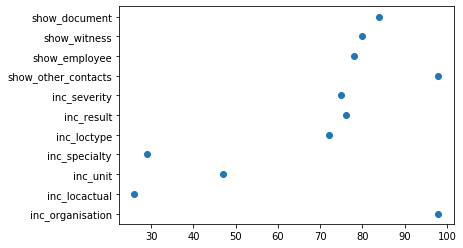

In [33]:
rounded_accuracies = [int(round(accuracy)) for accuracy in accuracies]
n_labels = len(labels)
#plt.bar(labels,rounded_accuracies);
plt.scatter(x=rounded_accuracies,y=labels)